In [1]:
import histogramGenerator
import test_infiniteLadder 
import numpy as np
from test_algorithms import computeMAPE
import matplotlib.pyplot as plt
import SSTA
from test_SSTA_Numpy import putTuplesIntoArray

from randomVariableHist_Numpy import RandomVariable

from examples_monteCarlo.infinite_ladder_montecarlo import MonteCarlo_inputs, MonteCarlo_nodes, get_moments_from_simulations


from Main.node import Node
from tabulate import tabulate
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [62]:
# test max computation

def testMax(numberOfBins, numberOfUnaries):

    mu1 = 12
    sigma1 = 2

    mu2 = 6
    sigma2 = 3

    
    numberOfSamples = 20000000
#     numberOfBins = 100
#     numberOfUnaries = 10000

    interval = (-5, 20)

    # DESIRED

    rv1 = np.random.normal(mu1, sigma1, numberOfSamples)
    rv2 = np.random.normal(mu2, sigma2, numberOfSamples)

    max1 = np.maximum(rv1, rv2)
    desired = np.array([np.mean(max1), np.std(max1)])


    # ACTUAL

    # histogram1
    h1 = histogramGenerator.get_gauss_bins_UNARY(mu1, sigma1, numberOfBins, numberOfSamples, interval, numberOfUnaries)
    h2 = histogramGenerator.get_gauss_bins_UNARY(mu2, sigma2, numberOfBins, numberOfSamples, interval, numberOfUnaries)

    max2 = h1.maxOfDistributionsQUAD_FORMULA_UNARY(h2)

    actual = np.array([max2.mean, max2.std])

        # debug plotting
    import matplotlib.pyplot as plt
    h1 = histogramGenerator.get_Histogram_from_UNARY(h1)
    h2 = histogramGenerator.get_Histogram_from_UNARY(h2)
    max2 = histogramGenerator.get_Histogram_from_UNARY(max2)
    
#     plt.hist(h1.edges[:-1], h1.edges, weights=h1.bins)
#     plt.hist(h2.edges[:-1], h2.edges, weights=h2.bins)
    plt.hist(max2.edges[:-1], max2.edges, weights=max2.bins)
    _ = plt.hist(max1, bins=numberOfBins, density='PDF', alpha=0.7)
    
    return (actual, desired)
    
        # TESTING

#     np.testing.assert_almost_equal(desired, actual, decimal=5)

[12.15        2.51793566] [12.07185172  1.95008521]
[ 0.64735951 29.11926379]


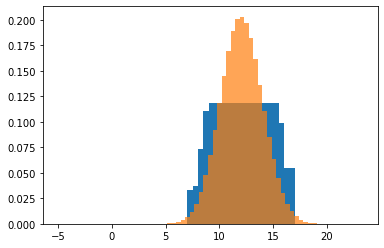

In [84]:
# test max as wanted

numberOfBins = 50
numberOfUnaries = 60

actual, desired = testMax(numberOfBins, numberOfUnaries)

MAPE = 100 * np.abs((actual - desired) / desired)



print(actual, desired)
print(MAPE)

In [99]:
# test mean computation

def testConvolution(numberOfBins, numberOfUnaries):

    mu1 = 7
    sigma1 = 3

    mu2 = 10
    sigma2 = 4

    
    numberOfSamples = 20000000
#     numberOfBins = 100
#     numberOfUnaries = 10000

    interval = (-5, 40)

    # DESIRED

    rv1 = np.random.normal(mu1, sigma1, numberOfSamples)
    rv2 = np.random.normal(mu2, sigma2, numberOfSamples)

    max1 = rv1 + rv2
    desired = np.array([np.mean(max1), np.std(max1)])


    # ACTUAL

    # histogram1
    h1 = histogramGenerator.get_gauss_bins_UNARY(mu1, sigma1, numberOfBins, numberOfSamples, interval, numberOfUnaries)
    h2 = histogramGenerator.get_gauss_bins_UNARY(mu2, sigma2, numberOfBins, numberOfSamples, interval, numberOfUnaries)

    
    rv1 = histogramGenerator.get_gauss_bins(mu1, sigma1, numberOfBins, numberOfSamples, interval)
    rv2 = histogramGenerator.get_gauss_bins(mu2, sigma2, numberOfBins, numberOfSamples, interval)

    
    max2 = h1.convolutionOfTwoVarsNaiveSAME_UNARY(h2)
#     max2 = rv1.convolutionOfTwoVarsShift(rv2)

    actual = np.array([max2.mean, max2.std])

    
    import matplotlib.pyplot as plt
    h1 = histogramGenerator.get_Histogram_from_UNARY(h1)
    h2 = histogramGenerator.get_Histogram_from_UNARY(h2)
    max2 = histogramGenerator.get_Histogram_from_UNARY(max2)
    
#     plt.hist(h1.edges[:-1], h1.edges, weights=h1.bins)
#     plt.hist(h2.edges[:-1], h2.edges, weights=h2.bins)
    plt.hist(max2.edges[:-1], max2.edges, weights=max2.bins)
    _ = plt.hist(max1, bins=numberOfBins, density='PDF', alpha=0.7)
    
    return (actual, desired)
    
        # TESTING

#     np.testing.assert_almost_equal(desired, actual, decimal=5)

[16.96060209  5.41580628] [17.00000833  4.99989348]
[0.23180127 8.3184331 ]


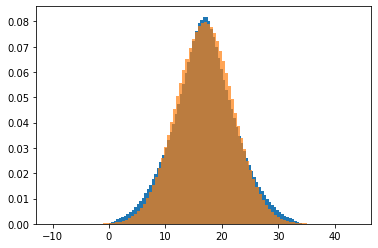

In [114]:
# test convolution as wanted

numberOfBins = 100
numberOfUnaries = 100
actual, desired = testConvolution(numberOfBins, numberOfUnaries)

MAPE = 100 * np.abs((actual - desired) / desired)

print(actual, desired)
print(MAPE)

In [4]:
# test infinite ladder function

def LadderNumpy(numberOfBins=100, numberOfUnaries=100, number_of_nodes=1, interval=(-8, 50)):

    n_samples = 2000000
    seed = 0

    gateParams = [0.0, 1.0]

    # fix a random seed seed exists
    if seed != None:
        seed = seed
        np.random.seed(seed)

        
    ####################################
    ####### Generate Input data ########
    ####################################

    # list with inputs' mean values
    input_means = [np.random.randint(20, 70) / 10 for _ in range(number_of_nodes + 1)]
    # list with inputs' stds
    input_stds = [np.random.randint(20, 130) / 100 for _ in range(number_of_nodes + 1)]

    # CVXPY

    constraints = []

    # generate inputs
    startingNodes = []
    for i in range(0, number_of_nodes + 1):
        g = histogramGenerator.get_gauss_bins_UNARY(input_means[i], input_stds[i], numberOfBins, n_samples,
                                                    interval, numberOfUnaries)

        node = Node(g)
        startingNodes.append(node)

        # generetate nodes
    generatedNodes = []
    for i in range(0, number_of_nodes):
        g = histogramGenerator.get_gauss_bins_UNARY(gateParams[0], gateParams[1], numberOfBins, n_samples, interval,
                                                    numberOfUnaries)

        node = Node(g)
        generatedNodes.append(node)

    # set circuit design

    # start
    startingNodes[0].setNextNodes([generatedNodes[0]])

    # upper part
    for i in range(1, number_of_nodes + 1):
        start = startingNodes[i]
        start.setNextNodes([generatedNodes[i - 1]])

        # lower part
    for i in range(0, number_of_nodes - 1):
        node = generatedNodes[i]
        node.setNextNodes([generatedNodes[i + 1]])

    delays = SSTA.calculateCircuitDelay(startingNodes, cvxpy=False, unary=True)

    delays = delays[number_of_nodes + 1:]

    rvs = []

    for gate in range(0, number_of_nodes):  # construct RVs

        finalBins = np.zeros((numberOfBins, numberOfUnaries))
        for bin in range(0, numberOfBins):
            for unary in range(0, numberOfUnaries):
                finalBins[bin, unary] = ((delays[gate].bins)[bin])[unary]

        rvs.append(RandomVariable(finalBins, generatedNodes[0].randVar.edges, unary=True))

    # simulate inputs
    nodes_simulation = [0 for _ in range(number_of_nodes)]
    inputs_simulation = MonteCarlo_inputs(input_means, input_stds, n_samples, 'Normal')

    # traverse the circuit
    nodes_simulation[0] = MonteCarlo_nodes(inputs_simulation[0], inputs_simulation[1], gateParams, n_samples)
    for i in range(1, number_of_nodes):
        nodes_simulation[i] = MonteCarlo_nodes(nodes_simulation[i - 1], inputs_simulation[i + 1], gateParams,
                                               n_samples)

    desired = get_moments_from_simulations(nodes_simulation)

        
    return np.array([rvs[-1].mean, rvs[-1].std]), np.array(desired[0])


In [27]:
numberOfNodes = 5
numberOfBins = 180
numberOfUnaries = 9

actual, desired = LadderNumpy(numberOfBins, numberOfUnaries, numberOfNodes)

# actual = np.zeros((numberOfNodes, 2))
# desired = np.zeros((numberOfNodes, 2))

# for i in range(0, numberOfNodes):
#     actual[i, 0] = actualNonForm[i].mean
#     actual[i, 1] = actualNonForm[i].std
    
#     desired[i, 0] = desiredNonForm[i, 0]
#     desired[i, 1] = desiredNonForm[i, 1]
    


MAPE = 100 * np.abs((actual - desired) / desired)

print(actual, desired)
print(MAPE)

[6.98333333 1.05237337] [6.99535243 1.2267176 ]
[ 0.17181548 14.21225447]


In [ ]:
        # HEAT MAPS

In [10]:
# compute MAPE heatmap for Convolution - takes a long time to compute

bins = 2
unaries = 2
start = 10

meanMAPE, stdMAPE = computeMAPE(bins, unaries, start, testConvolution)


bins:10
unaries: 10
[18.85        3.36749165]
[20.00079693  2.38548551]
[ 5.7537554  41.16588129]
bins:10
unaries: 12
[18.69117647  3.28491361]
[19.99978649  2.38576515]
[ 6.54311997 37.68805399]
bins:12
unaries: 10
[19.375  1.875]
[19.99901596  2.38475026]
[ 3.12023333 21.37541493]
bins:12
unaries: 12
[18.79807692  2.88461538]
[20.00006213  2.38468422]
[ 6.00990735 20.9642502 ]


In [17]:
meanMAPE = np.flip(meanMAPE, 0)
meanMAPE = np.around(meanMAPE, 2)

stdMAPE = np.around(stdMAPE, 2)
stdMAPE = np.flip(stdMAPE, 0)

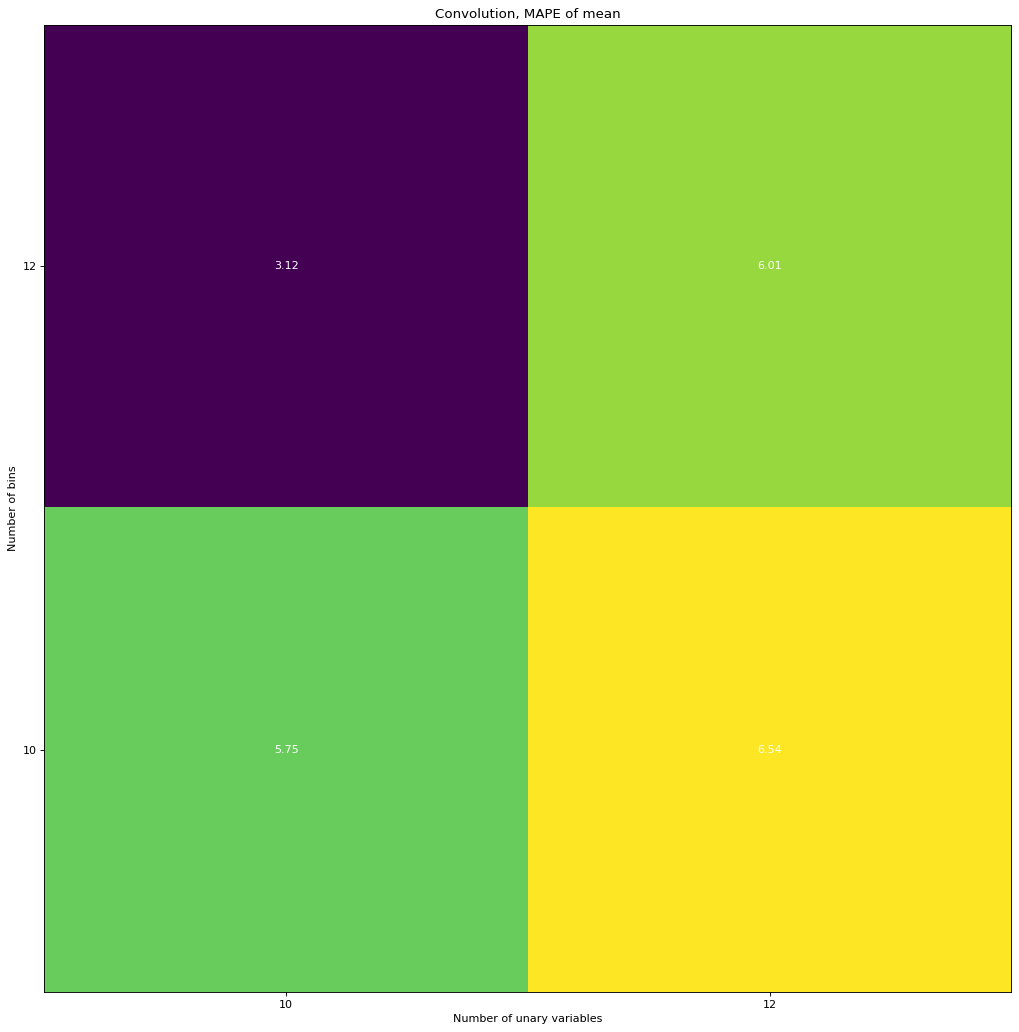

[[3.12 6.01]
 [5.75 6.54]]


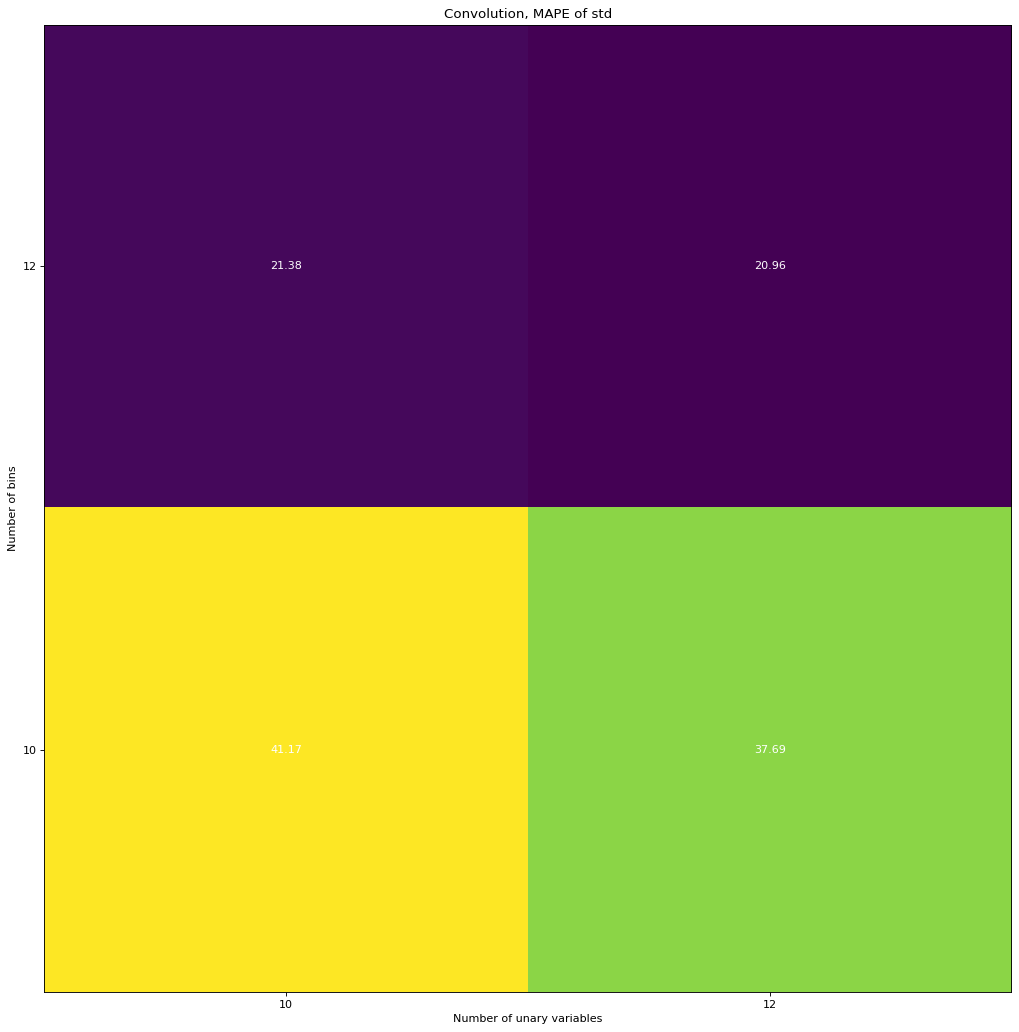

In [18]:
# plot heatmap

fig, ax = plt.subplots(figsize=(13, 13), dpi=80)

im = ax.imshow(meanMAPE)

for i in range(0, meanMAPE.shape[0], ):
    for j in range(meanMAPE.shape[1]):
        text = ax.text(j, i, meanMAPE[i, j],
                       ha="center", va="center", color="w")

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, unaries), np.arange(start, start+unaries*2, step=2))
plt.yticks(np.arange(0, bins), np.flip(np.arange(start, start+bins*2, step=2)))

plt.xlabel('Number of unary variables')
plt.ylabel('Number of bins')
plt.title('Convolution, MAPE of mean')

fig.tight_layout()

plt.savefig("Inputs/testConvolution/meanHeatMap.jpeg", dpi=300)
plt.show()



fig, ax = plt.subplots(figsize=(13, 13), dpi=80)
im = ax.imshow(stdMAPE)

for i in range(0, stdMAPE.shape[0], ):
    for j in range(stdMAPE.shape[1]):
        text = ax.text(j, i, stdMAPE[i, j],
                       ha="center", va="center", color="w")

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, unaries), np.arange(start, start+unaries*2, step=2))
plt.yticks(np.arange(0, bins), np.flip(np.arange(start, start+bins*2, step=2)))



plt.xlabel('Number of unary variables')
plt.ylabel('Number of bins')
plt.title('Convolution, MAPE of std')


fig.tight_layout()

plt.savefig("Inputs/testConvolution/stdHeatMap.jpeg", dpi=300)
plt.show()

In [19]:
# compute MAPE heatmap for MAXIMUM - takes a long time to compute


bins = 2
unaries = 2
start = 10

meanMAPE, stdMAPE = computeMAPE(bins, unaries, start, testMax)


bins:10
unaries: 10
[11.83823529  1.82495201]
[12.07130937  1.95038811]
[1.93081025 6.43134083]
bins:10
unaries: 12
[11.75        1.87082869]
[12.07274924  1.95075269]
[2.67336986 4.09708493]
bins:12
unaries: 10
[11.66666667  2.13478141]
[12.07239229  1.95057369]
[3.36077234 9.44377135]
bins:12
unaries: 12
[11.74107143  1.96715834]
[12.07184394  1.94996746]
[2.74003306 0.88159838]


In [20]:
meanMAPE = np.around(meanMAPE, 2)
meanMAPE = np.flip(meanMAPE, 0)

stdMAPE = np.around(stdMAPE, 2)
stdMAPE = np.flip(stdMAPE, 0)

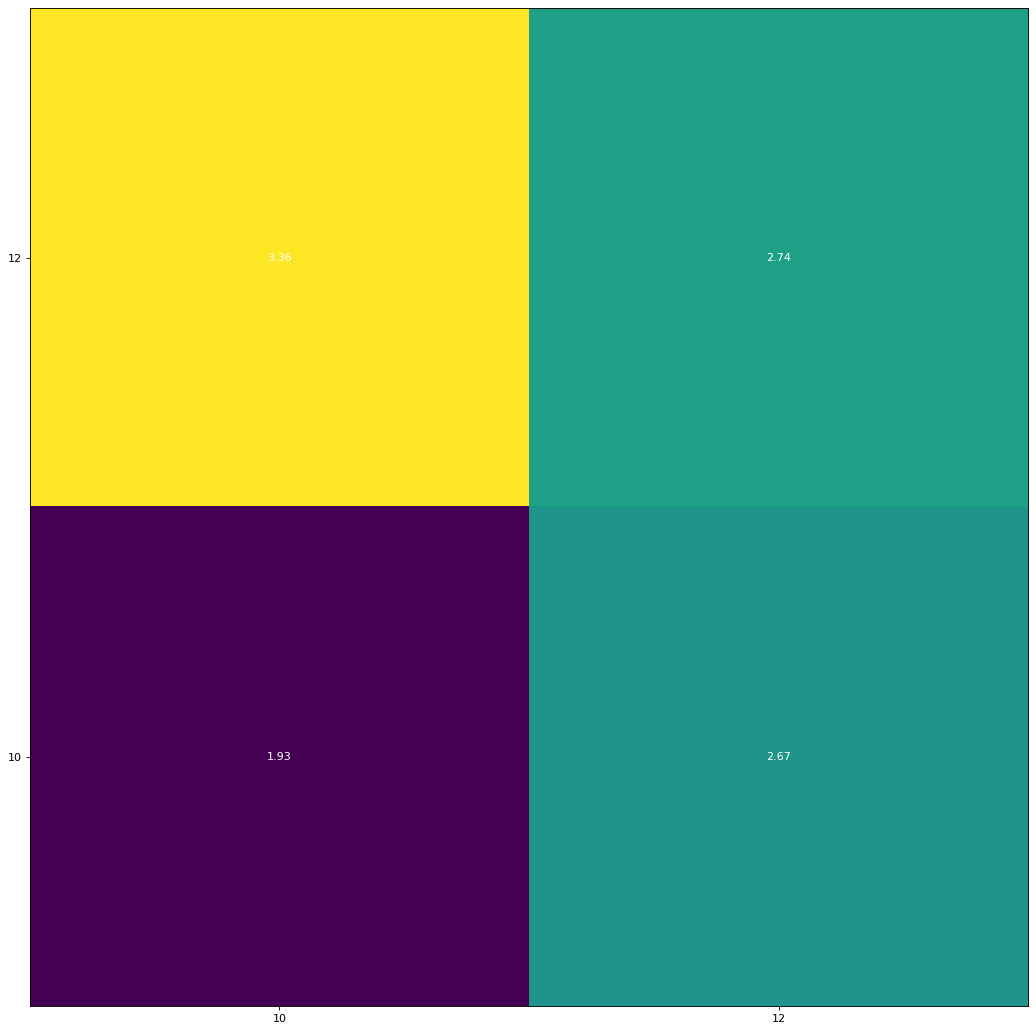

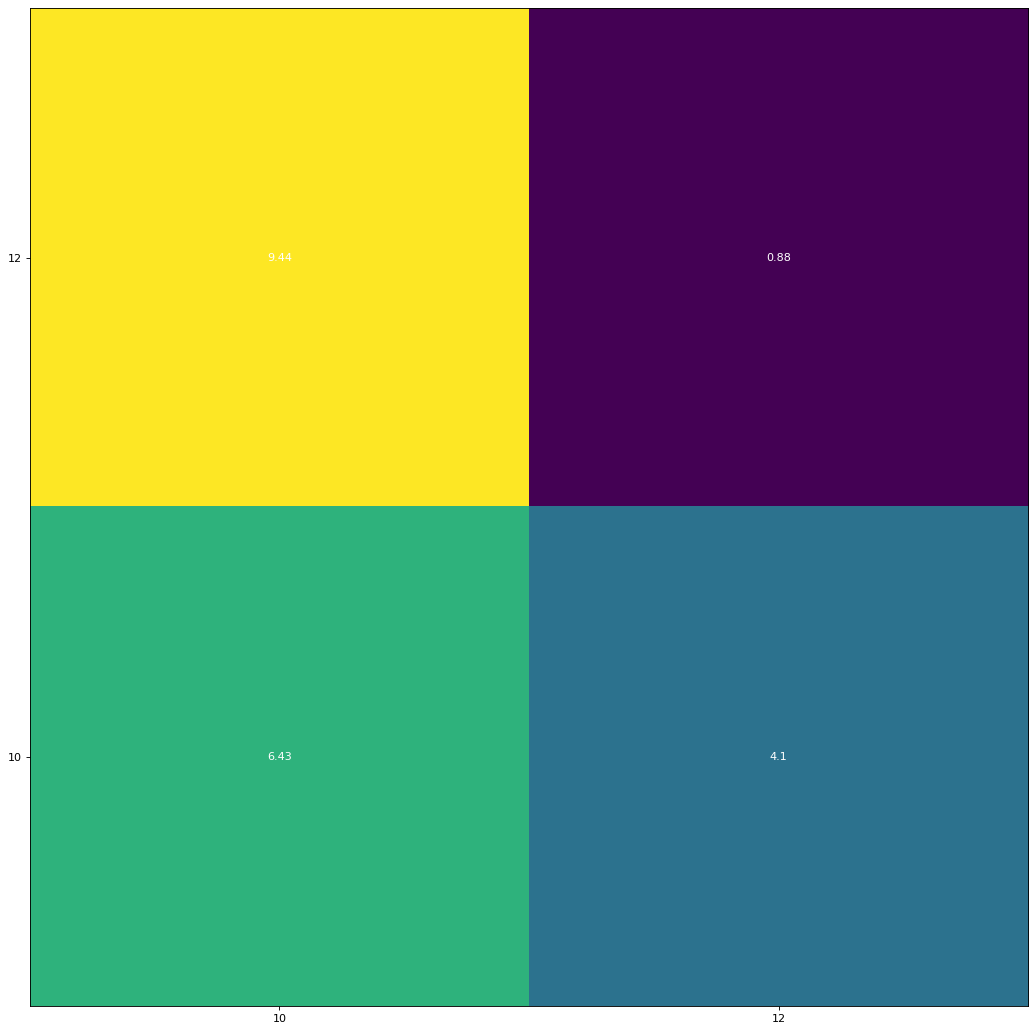

In [21]:
# plot heatmap

fig, ax = plt.subplots(figsize=(13, 13), dpi=80)

im = ax.imshow(meanMAPE)

for i in range(0, meanMAPE.shape[0], ):
    for j in range(meanMAPE.shape[1]):
        text = ax.text(j, i, meanMAPE[i, j],
                       ha="center", va="center", color="w")

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, unaries), np.arange(start, start+unaries*2, step=2))
plt.yticks(np.arange(0, bins), np.flip(np.arange(start, start+bins*2, step=2)))


fig.tight_layout()

plt.savefig("Inputs/testMAX/meanHeatMap.jpeg", dpi=100)
plt.show()



fig, ax = plt.subplots(figsize=(13, 13), dpi=80)
im = ax.imshow(stdMAPE)

for i in range(0, stdMAPE.shape[0], ):
    for j in range(stdMAPE.shape[1]):
        text = ax.text(j, i, stdMAPE[i, j],
                       ha="center", va="center", color="w")

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, unaries), np.arange(start, start+unaries*2, step=2))
plt.yticks(np.arange(0, bins), np.flip(np.arange(start, start+bins*2, step=2)))


fig.tight_layout()

plt.savefig("Inputs/testMAX/stdHeatMap.jpeg", dpi=100)
plt.show()

In [ ]:
# compute MAPE heatmap for infinite ladder - takes a long time to compute

bins = 25
unaries = 25
start = 10

meanMAPE, stdMAPE = computeMAPE(bins, unaries, start, LadderNumpy)


In [ ]:
meanMAPE = np.around(meanMAPE, 2)
meanMAPE = np.flip(meanMAPE, 0)

stdMAPE = np.around(stdMAPE, 2)
stdMAPE = np.flip(stdMAPE, 0)

In [ ]:
# plot heatmap

fig, ax = plt.subplots(figsize=(13, 13), dpi=80)

im = ax.imshow(meanMAPE)

for i in range(0, meanMAPE.shape[0], ):
    for j in range(meanMAPE.shape[1]):
        text = ax.text(j, i, meanMAPE[i, j],
                       ha="center", va="center", color="w")

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, unaries), np.arange(start, start+unaries*2, step=2))
plt.yticks(np.arange(0, bins), np.flip(np.arange(start, start+bins*2, step=2)))


fig.tight_layout()

plt.savefig("Inputs/testInfiniteLadder/meanHeatMap.jpeg", dpi=100)
plt.show()



fig, ax = plt.subplots(figsize=(13, 13), dpi=80)
im = ax.imshow(stdMAPE)

for i in range(0, stdMAPE.shape[0], ):
    for j in range(stdMAPE.shape[1]):
        text = ax.text(j, i, stdMAPE[i, j],
                       ha="center", va="center", color="w")

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks(np.arange(0, unaries), np.arange(start, start+unaries*2, step=2))
plt.yticks(np.arange(0, bins), np.flip(np.arange(start, start+bins*2, step=2)))


fig.tight_layout()

plt.savefig("Inputs/testInfiniteLadder/stdHeatMap.jpeg", dpi=100)
plt.show()